# Part 2 - Classification with PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Hyperparameters

In [2]:
device = 'cuda'
n_epochs = 10
batch_size_train = 128
batch_size_test = 32
learning_rate = 0.00001
momentum = 0.9

# Prepare CIFAR10 image dataset

Using torchvision api to download MNIST data

In [3]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

train_data = torchvision.datasets.FashionMNIST('./data', train=True, download=True,
                                       transform=transform)
validation_data = torchvision.datasets.FashionMNIST('./data', train=False, download=True,
                                      transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, 
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size_test, 
                                           shuffle=True)

# Define Model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [5]:
# Initialize model and send to GPU
network = Net().to(device)

# Set algorithm for parameter update
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

# Train Model

In [6]:
# Almost the same format with training loop.
# But, without .backward(), .step()
# Also using different data loader.
def evaluate():
    network.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.shape[0], -1)
            output = network(data)
            val_loss += F.nll_loss(output, target, size_average=False).item() 
            
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    val_loss /= len(validation_loader.dataset)
    val_losses.append(val_loss)
    print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset),
        100. * correct / len(validation_loader.dataset)))

In [7]:
network

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

In [8]:
train_losses, train_counter, val_losses = [], [], []

In [9]:
for epoch in range(1, n_epochs + 1):

    # Print training loss for every 10 batch
    log_interval = 10

    # Set model to training mode
    # Change behavior of some layers like batchnorm, dropout, etc
    network.train()

    for batch_idx, (data, target) in enumerate(train_loader):

        # Send tensor to specified device
        # Default on CPU
        # Sending them to GPU OR CUDA
        data, target = data.to(device), target.to(device)

        # Reset all gradient to zero after each iteration
        # To prevent gradient accumulation
        optimizer.zero_grad()

        # # Change shape of input data to fit format of fully connected
        data = data.view(data.shape[0], -1)

        # Forward pass
        output = network(data)
        # Loss Calculation
        loss = F.nll_loss(output, target)

        # Calculate the update value for every parameters
        # Does not update parameter value
        loss.backward()

        # Update all parameters according to the gradient value
        optimizer.step()
        
        # Print training loss
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    # Perform evaluation
    evaluate()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307971
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.311948
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.301674
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.303104
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.310769
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.310230
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.308967
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.298877
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.305055
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.301081
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.315619
Train Epoch: 1 [14080/60000 (23%)]	Loss: 2.294065
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.302971
Train Epoch: 1 [16640/60000 (28%)]	Loss: 2.301956
Train Epoch: 1 [17920/60000 (30%)]	Loss: 2.300116
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.306979
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.307964
Train Epoch: 1 [21760/60000 (36%)]	Loss: 2.297075
Train Epoch: 1 [23040/60000 (38%)]	Loss: 2.303263
Train Epoch: 1 [24320/60000 (41%)]	Loss: 2.306002
Train Epoch: 1 [

# View Evaluation

In [10]:
# Evaluate on one batch only
examples = enumerate(validation_loader)
batch_idx, (example_data, example_targets) = next(examples)

# To run model without performing grading parameters
with torch.no_grad():

    # Prepare dataset
    pred_data = example_data
    pred_data = pred_data.view(pred_data.shape[0], -1)

    # Set model to evaluation mode
    network.eval()

    # Inference
    predictions = network(pred_data.to(device))

    # Format predictions to get labels
    predicted_labels = predictions.data.max(1, keepdim=True)[1].cpu().detach().numpy()

In [11]:
fashion_labels = ["T-shirt/top", "Trouser", "Pullover", 
                  "Dress", "Coat", "Sandal", "Shirt", 
                  "Sneaker", "Bag", "Ankle boot"]

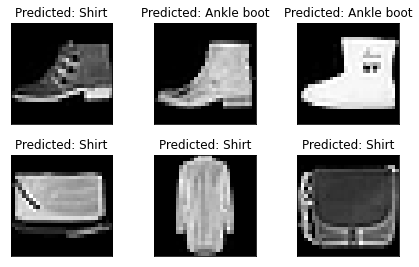

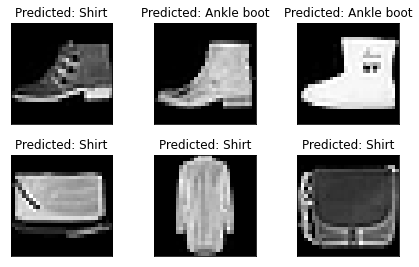

In [12]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Predicted: {}".format(fashion_labels[predicted_labels[i][0]]))
    plt.xticks([])
    plt.yticks([])
fig

### View model weights

In [13]:
for name, param in network.state_dict().items():
    print("Layer: ", name)
    print(param)
    print()

Layer:  fc1.weight
tensor([[-0.0220,  0.0267,  0.0058,  ...,  0.0053,  0.0197,  0.0253],
        [-0.0257,  0.0068,  0.0118,  ..., -0.0248,  0.0301,  0.0024],
        [ 0.0258,  0.0356, -0.0192,  ..., -0.0297, -0.0321,  0.0260],
        ...,
        [ 0.0116, -0.0100,  0.0156,  ..., -0.0201,  0.0225, -0.0202],
        [-0.0277,  0.0351, -0.0347,  ...,  0.0201,  0.0031, -0.0275],
        [-0.0205,  0.0214, -0.0063,  ...,  0.0177, -0.0341,  0.0141]],
       device='cuda:0')

Layer:  fc1.bias
tensor([-2.4285e-02,  3.3695e-02,  1.2884e-02,  3.5255e-02,  6.7548e-03,
         1.9411e-02,  2.0017e-02,  2.7183e-02, -3.4434e-02,  8.9119e-03,
         1.3121e-02,  1.2831e-02, -1.9941e-02,  3.3297e-02,  2.2363e-02,
        -1.7562e-02, -1.6060e-02,  9.2808e-03,  3.1963e-02,  1.9685e-02,
         7.5859e-03, -2.9045e-02, -5.3001e-03,  2.3263e-02, -2.2804e-02,
         2.9957e-03, -7.2482e-03, -3.4849e-02,  4.6390e-03, -3.0335e-02,
         7.3111e-04,  2.4710e-02, -1.4909e-03,  1.3794e-02, -1.3214